In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from rasterio.transform import xy
import pandas as pd
import xarray as xr
import cartopy.mpl.gridliner as gridliner

In [3]:
# Load the NetCDF files
ds = xr.open_dataset('/home/cdalden/summa_setup/analysis/crust_stats_ski_snotels.nc')

sntls = pd.read_csv('/home/cdalden/summa_setup/analysis/sntl_list_ski_temps.csv', index_col=0)


In [4]:
ds

<xarray.Dataset> Size: 187kB
Dimensions:             (site: 51, time: 25, model_run: 3)
Coordinates:
  * time                (time) datetime64[ns] 200B 2000-01-01 ... 2024-01-01
  * model_run           (model_run) <U7 84B 'current' '+2K' '+4K'
  * site                (site) <U17 3kB 'stevenspass' ... 'sylvanroad'
Data variables:
    mean_crusts         (site, time, model_run) float64 31kB ...
    crust_days          (site, time, model_run) float64 31kB ...
    snow_on             (site, time, model_run) float64 31kB ...
    crusts_binary       (site, time, model_run) float64 31kB ...
    isothermal_days     (site, time, model_run) float64 31kB ...
    percent_crust_days  (site, time, model_run) float64 31kB ...

/tmp/ipykernel_15727/722983248.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('PuOr')
/tmp/ipykernel_15727/722983248.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  dem_colormap = matplotlib.cm.get_cmap('winter')


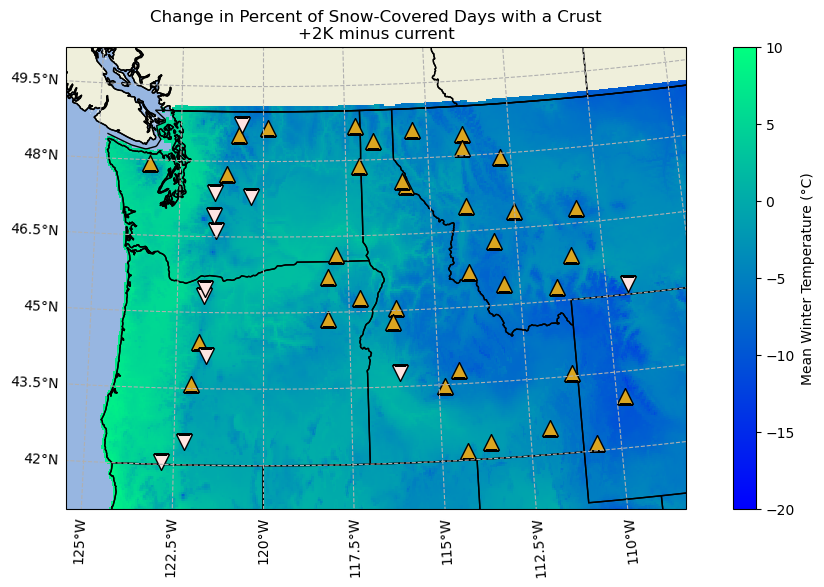

In [5]:
# Path to the DEM file
bil_file_path = '/home/cdalden/summa_setup/analysis/PRISM_DJF_tmean_30yr_normal_4kmM5.bil'

# Open the DEM file using rasterio
with rasterio.open(bil_file_path) as dem_dataset:
    # Read the DEM data
    dem_data = dem_dataset.read(1)  # Read the first band

    # Replace -9999 with NaN
    dem_data = np.where(dem_data == -9999, np.nan, dem_data)

    # Get the affine transformation
    dem_transform = dem_dataset.transform

    # Get the coordinates of the corners
    dem_rows, dem_cols = dem_data.shape
    lon_min, lat_max = xy(dem_transform, 0, 0)
    lon_max, lat_min = xy(dem_transform, dem_rows, dem_cols)

    # Create arrays of latitude and longitude values
    lons = np.linspace(lon_min, lon_max, dem_cols)
    lats = np.linspace(lat_max, lat_min, dem_rows)

    # Create a meshgrid of latitude and longitude values
    lon_grid, lat_grid = np.meshgrid(lons, lats)

# Assuming ds and sntls are already defined and contain the necessary data
comparison_run = '+2K'

# Calculate 'percent_crust_days' for 'current' and '+2K'
ds['percent_crust_days'] = ds['crusts_binary'] / ds['snow_on'] * 100
ds_avg_current = ds['percent_crust_days'].sel(model_run='current').mean(dim='time')
ds_avg_2K = ds['percent_crust_days'].sel(model_run=comparison_run).mean(dim='time')

# Calculate the difference
ds_diff = ds_avg_2K - ds_avg_current

# Convert the Dataset to a DataFrame
df_diff = ds_diff.to_dataframe().reset_index()

# Merge the difference DataFrame with the original DataFrame on the site column
df_merged = pd.merge(sntls, df_diff, left_on='site_name', right_on='site', how='inner')  # Use 'inner' join

# Normalize the 'percent_crust_days' column for color mapping
norm = matplotlib.colors.Normalize(vmin=df_merged['percent_crust_days'].min(),
                                   vmax=df_merged['percent_crust_days'].max())
colormap = matplotlib.cm.get_cmap('PuOr')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-120, central_latitude=47.5))
ax.set_extent([sntls['lon'].min() - 2, sntls['lon'].max() + 1, sntls['lat'].min() - 1, sntls['lat'].max() + 1], crs=ccrs.PlateCarree())

# Plot the DEM data
dem_norm = matplotlib.colors.Normalize(vmin=-20, vmax=10)
dem_colormap = matplotlib.cm.get_cmap('winter')
ax.pcolormesh(lon_grid, lat_grid, dem_data, cmap=dem_colormap, shading='auto', transform=ccrs.PlateCarree(), norm=dem_norm)

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points as arrows
for idx, row in df_merged.iterrows():
    if pd.notna(row['percent_crust_days']):
        # color = matplotlib.colors.to_hex(colormap(norm(row['percent_crust_days'])))
        color = 'goldenrod' if row['percent_crust_days'] > 0 else 'mistyrose'
        marker = '^' if row['percent_crust_days'] > 0 else 'v'
        # size = np.abs(row['percent_crust_days']) * 1  # Adjust the scaling factor as needed
        size = 12
        ax.plot(row['lon'], row['lat'], marker=marker, color=color, markersize=size, markeredgecolor='k', transform=ccrs.PlateCarree())

# Add a legend for the arrow sizes
for magnitude in [10, 20, 30]:  # Example magnitudes
    ax.plot([], [], marker='^', color='k', markersize=magnitude * 1, label=f'{magnitude}%')

# ax.legend(title='Arrow Size Scale', loc='upper right')

# Create a colorbar for the DEM data
sm = plt.cm.ScalarMappable(cmap=dem_colormap, norm=dem_norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='Mean Winter Temperature (°C)')

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

ax.set_title(f'Change in Percent of Snow-Covered Days with a Crust\n{comparison_run} minus current')

# Show the map
plt.show()

<>:60: SyntaxWarning: invalid escape sequence '\c'
<>:60: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_15727/72754898.py:60: SyntaxWarning: invalid escape sequence '\c'
  fig.colorbar(sm, ax=ax, orientation='vertical', label=f'Temperature [$^\circ$C]')
/tmp/ipykernel_15727/72754898.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('Blues_r')
/tmp/ipykernel_15727/72754898.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  dem_colormap = matplotlib.cm.get_cmap('Blues_r')


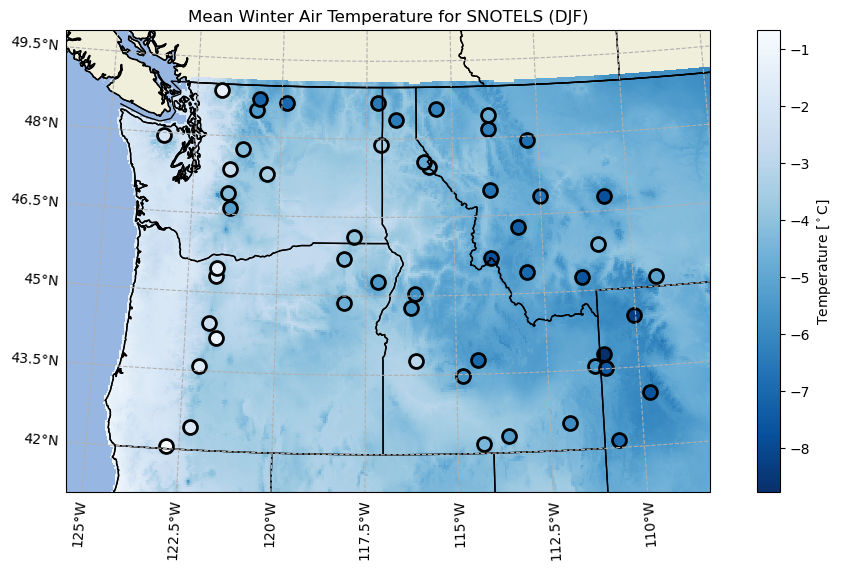

In [6]:
# Path to the DEM file
bil_file_path = '/home/cdalden/summa_setup/analysis/PRISM_DJF_tmean_30yr_normal_4kmM5.bil'

# Open the DEM file using rasterio
with rasterio.open(bil_file_path) as dem_dataset:
    # Read the DEM data
    dem_data = dem_dataset.read(1)  # Read the first band

    # Replace -9999 with NaN
    dem_data = np.where(dem_data == -9999, np.nan, dem_data)

    # Get the affine transformation
    dem_transform = dem_dataset.transform

    # Get the coordinates of the corners
    dem_rows, dem_cols = dem_data.shape
    lon_min, lat_max = xy(dem_transform, 0, 0)
    lon_max, lat_min = xy(dem_transform, dem_rows, dem_cols)

    # Create arrays of latitude and longitude values
    lons = np.linspace(lon_min, lon_max, dem_cols)
    lats = np.linspace(lat_max, lat_min, dem_rows)

    # Create a meshgrid of latitude and longitude values
    lon_grid, lat_grid = np.meshgrid(lons, lats)

# Normalize the 'percent_crust_days' column for color mapping
norm = matplotlib.colors.Normalize(vmin=sntls['mean_temp_djf'].min(), vmax=sntls['mean_temp_djf'].max())
colormap = matplotlib.cm.get_cmap('Blues_r')

# Create a map centered around the mean coordinates
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-117, central_latitude=45))
ax.set_extent([sntls['lon'].min()-2, sntls['lon'].max()+1, sntls['lat'].min()-1, sntls['lat'].max()+1], crs=ccrs.PlateCarree())

# Plot the DEM data
dem_norm = matplotlib.colors.Normalize(vmin=-20, vmax=10)
dem_colormap = matplotlib.cm.get_cmap('Blues_r')
ax.pcolormesh(lon_grid, lat_grid, dem_data, cmap=dem_colormap, shading='auto', transform=ccrs.PlateCarree(), norm=dem_norm)

# add colorbar for DEM data
sm = plt.cm.ScalarMappable(cmap=dem_colormap, norm=dem_norm)

# Add the satellite imagery
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)  # Add state boundaries

# Add the points colored by the difference in 'percent_crust_days'
for idx, row in sntls.iterrows():
    color = matplotlib.colors.to_hex(colormap(norm(row['mean_temp_djf'])))
    ax.scatter(row['lon'], row['lat'], marker='o', color=color, s=100, edgecolor='k', 
            transform=ccrs.PlateCarree(), linewidths=2)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label=f'Temperature [$^\circ$C]')

# Add x and y ticks for lon and lat
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ls='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = gridliner.LONGITUDE_FORMATTER
gl.yformatter = gridliner.LATITUDE_FORMATTER

ax.set_title(f'Mean Winter Air Temperature for SNOTELS (DJF)')

# Show the map
plt.show()